# SINGLE PREDICTION USING MULTIVARIATE FEATURES WITH LSTM SEQ2SEQ
## HERE WE USED: 12h for running the running inference over the next 1h

In [1]:
import tensorflow as tf
# Data Loader Parameters
BATCH_SIZE = 128
BUFFER_SIZE = 100

# LSTM Parameters
EVALUATION_INTERVAL = 200
PATIENCE = 10

PAST_WINDOW_SIZE = 144                    # ----------- 12H
FUTURE_WINDOW_SIZE = 12                   # ----------- 1H
STEP = 3

# Reproducibility
SEED = 13
tf.random.set_seed(SEED)

2023-06-12 16:42:19.083481: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-12 16:42:19.110640: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from keras.models import Sequential, save_model, load_model
from keras.layers import Bidirectional, LSTM, Dropout, Dense
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_percentage_error
import os
import time
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
from tensorflow.keras.layers import BatchNormalization, ConvLSTM2D, RepeatVector
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from tensorflow.keras.layers import TimeDistributed

# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

# read dataset may2023
df = pd.read_pickle("../../data/20230319_RTU_Dataset_PPC-Lab/combined_may2023.pkl")  

In [3]:
def create_sequence(dataset, target, window, future):
    x_sequence, y_sequence = [], []
    for index in range(len(dataset) - window - future):
        x_sequence.append(dataset[index: index + window])
        y_sequence.append(target[index + window: index + window + future])
    return (np.asarray(x_sequence), np.asarray(y_sequence))

def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

def multivariate_multioutput_data(dataset, target, start_index, end_index, history_size, target_size, step):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        labels.append(target[i:i+target_size])

    return np.array(data)[:,:,:,np.newaxis,np.newaxis], np.array(labels)[:,:,:,np.newaxis,np.newaxis]

def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

def create_time_steps(length):
    return list(range(-length, 0))
    
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

def evaluate_predictions(predictions_seq, y_test_seq):
    MSE = []
    for pred in range(len(y_test)):
        mse = mean_squared_error(y_test_seq[pred], predictions_seq[pred])
        MSE.append(mse)
    return MSE

def find_max_error(predictions, y_test, mean_mse, std_mse):
    max_errors = 0
    for pred in range(len(y_test)):
        mse = mean_squared_error(y_test[pred], predictions[pred])
    if mse > mean_mse + std_mse:
        max_errors += 1
    return max_errors

def build_model(input_timesteps, output_timesteps, num_links, num_inputs):    
    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, num_inputs, 1, 1)))
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = 64, kernel_size = (10, 1),                       
                         padding = 'same', 
                         return_sequences = False))
    
    model.add(Dropout(0.30, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))

#     model.add(ConvLSTM2D(name ='conv_lstm_2',
#                          filters = 64, kernel_size = (5, 1), 
#                          padding='same',
#                          return_sequences = False))
    
#     model.add(Dropout(0.20, name = 'dropout_2'))
#     model.add(BatchNormalization(name = 'batch_norm_2'))
    
    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, num_inputs, 1, 64)))
    
#     model.add(ConvLSTM2D(name ='conv_lstm_3',
#                          filters = 64, kernel_size = (10, 1), 
#                          padding='same',
#                          return_sequences = True))
    
#     model.add(Dropout(0.20, name = 'dropout_3'))
#     model.add(BatchNormalization(name = 'batch_norm_3'))
    
    model.add(ConvLSTM2D(name ='conv_lstm_4',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    model.add(Dense(units=1, name = 'dense_2'))

#     optimizer = RMSprop() #lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.9)
#     optimizer = tf.keras.optimizers.Adam(0.1)
    optimizer = tf.keras.optimizers.RMSprop(lr=0.003, clipvalue=1.0)
    model.compile(loss = "mse", optimizer = optimizer, metrics = ['mae', 'mse'])
    return model

def my_mean_absolute_percentage_error(y_true, y_pred):
    error = 0
    for i in range(len(y_true)):
        if y_true[i] != 0:
            error += abs((y_true[i] - y_pred[i]) / y_true[i])
    
    mape = (error / len(y_true)) * 100
    return mape

In [4]:
# Normalizing the values
standard_scaler = preprocessing.StandardScaler()
print(df.head())
scaled_df = standard_scaler.fit_transform(df[['MEM_USAGE', 'CPU_USAGE', 'TEMP']])
print(scaled_df[:10])
print(scaled_df[:,1])

training_size = int(len(scaled_df) * 0.8)

print('Size of the dataset: %d' % (len(scaled_df)))
print('Size of training: %d' % (training_size))


   MEM_USAGE  CPU_USAGE     PS1_V    TEMP
0  35.555417  27.343750  5.435294  28.687
1  35.555417   6.367041  5.435294  28.687
2  35.555417   7.142857  5.435294  28.687
3  35.555417  27.306273  5.435294  28.687
4  35.555417   5.639098  5.435294  28.687
[[ 0.48139574  1.13540371  0.74576055]
 [ 0.48139574 -0.66263387  0.74576055]
 [ 0.48139574 -0.59613411  0.74576055]
 [ 0.48139574  1.13219134  0.74576055]
 [ 0.48139574 -0.7250302   0.74576055]
 [ 0.48139574 -0.73742406  0.74576055]
 [ 0.48139574 -0.6369512   0.74576055]
 [ 0.48139574 -0.91168167  0.74576055]
 [ 0.48139574 -0.63268673  0.74576055]
 [ 0.48139574 -0.27087286  0.74576055]]
[ 1.13540371 -0.66263387 -0.59613411 ... -0.69409514 -0.51872237
 -0.07440583]
Size of the dataset: 3733
Size of training: 2986


In [5]:
scaled_df

array([[ 0.48139574,  1.13540371,  0.74576055],
       [ 0.48139574, -0.66263387,  0.74576055],
       [ 0.48139574, -0.59613411,  0.74576055],
       ...,
       [-1.80536352, -0.69409514,  0.98794801],
       [-1.80536352, -0.51872237,  0.98794801],
       [-1.80536352, -0.07440583,  0.98794801]])

# MULTIVARIATE TO SINGLE FEATURE CPU

In [6]:
x_train_multi, y_train_multi = multivariate_data(scaled_df, scaled_df[:, 1], 0,
                                                 training_size, PAST_WINDOW_SIZE,
                                                 FUTURE_WINDOW_SIZE, STEP)
x_val_multi, y_val_multi = multivariate_data(scaled_df, scaled_df[:, 1],
                                             training_size, None, PAST_WINDOW_SIZE,
                                                 FUTURE_WINDOW_SIZE, STEP)

In [7]:
x_train_multi.shape

(2842, 48, 3)

In [8]:
y_train_multi.shape

(2842, 12)

In [9]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

2023-06-12 16:42:23.406728: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-12 16:42:23.415612: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-12 16:42:23.415866: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [10]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(FUTURE_WINDOW_SIZE))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
print(multi_step_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 32)            4608      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 12)                204       
                                                                 
Total params: 7,948
Trainable params: 7,948
Non-trainable params: 0
_________________________________________________________________
None


2023-06-12 16:42:24.051305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 16:42:24.052104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-12 16:42:24.052652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [11]:
for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)

2023-06-12 16:42:24.746880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [591,12]
	 [[{{node Placeholder/_1}}]]
2023-06-12 16:42:24.977508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 16:42:24.978552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 

4/4 [==============================] - 1s 5ms/step
(128, 12)


In [12]:
EPOCHS = 10

early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)
multi_step_history = multi_step_model.fit(train_data_multi,
                                          epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=EVALUATION_INTERVAL,
                                          callbacks=[early_stopping])

Epoch 1/10


2023-06-12 16:42:27.571067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [2842,48,3]
	 [[{{node Placeholder/_0}}]]
2023-06-12 16:42:27.725563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 16:42:27.726262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tens

199/200 [============================>.] - ETA: 0s - loss: 0.6520

2023-06-12 16:42:33.992568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [591,12]
	 [[{{node Placeholder/_1}}]]
2023-06-12 16:42:34.108243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 16:42:34.109004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 

200/200 [==============================] - 9s 35ms/step - loss: 0.6519 - val_loss: 0.6584
Epoch 2/10
200/200 [==============================] - 5s 26ms/step - loss: 0.6399 - val_loss: 0.6765
Epoch 3/10
200/200 [==============================] - 5s 26ms/step - loss: 0.6403 - val_loss: 0.6710
Epoch 4/10
200/200 [==============================] - 5s 26ms/step - loss: 0.6387 - val_loss: 0.6866


In [13]:
multi_step_model.save('best_multistep_multivariate_to_single_cpu.h5')

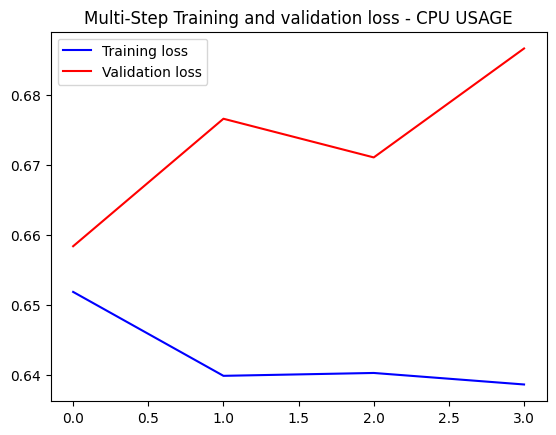

In [14]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss - CPU USAGE')

In [15]:
from tensorflow import keras
multi_step_model = keras.models.load_model("./best_multistep_multivariate_to_single_cpu.h5")

2023-06-12 16:42:59.971092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 16:42:59.973195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-12 16:42:59.974992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-12 16:43:01.407240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [591,12]
	 [[{{node Placeholder/_1}}]]
2023-06-12 16:43:01.573869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 16:43:01.574550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 

4/4 [==============================] - 0s 5ms/step


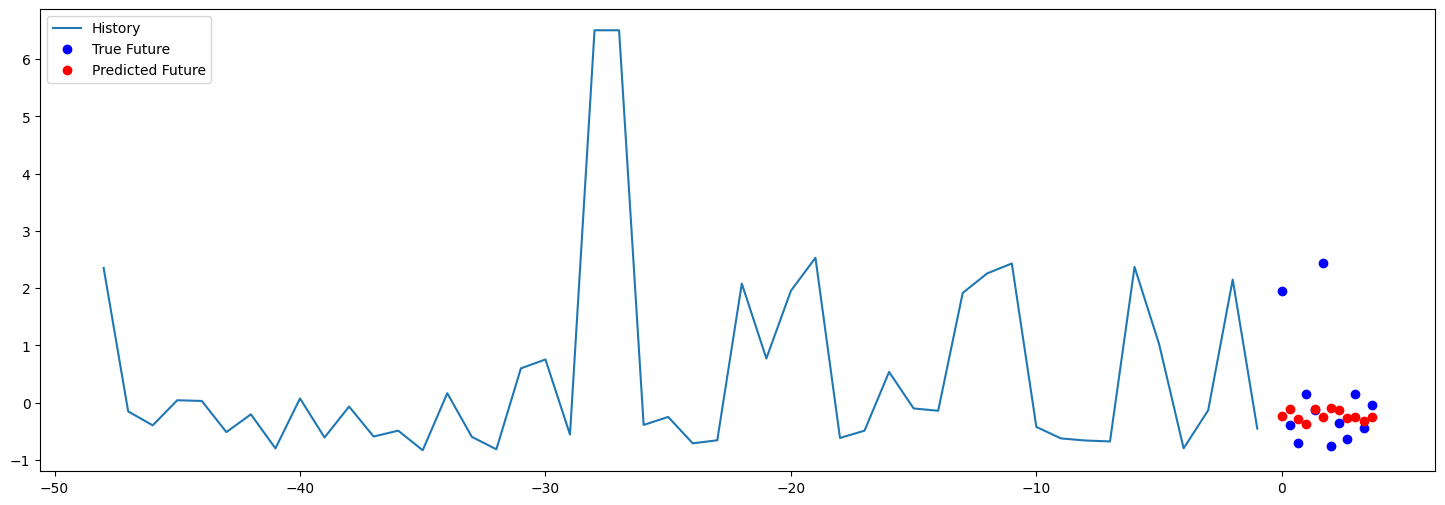

4/4 [==============================] - 0s 4ms/step


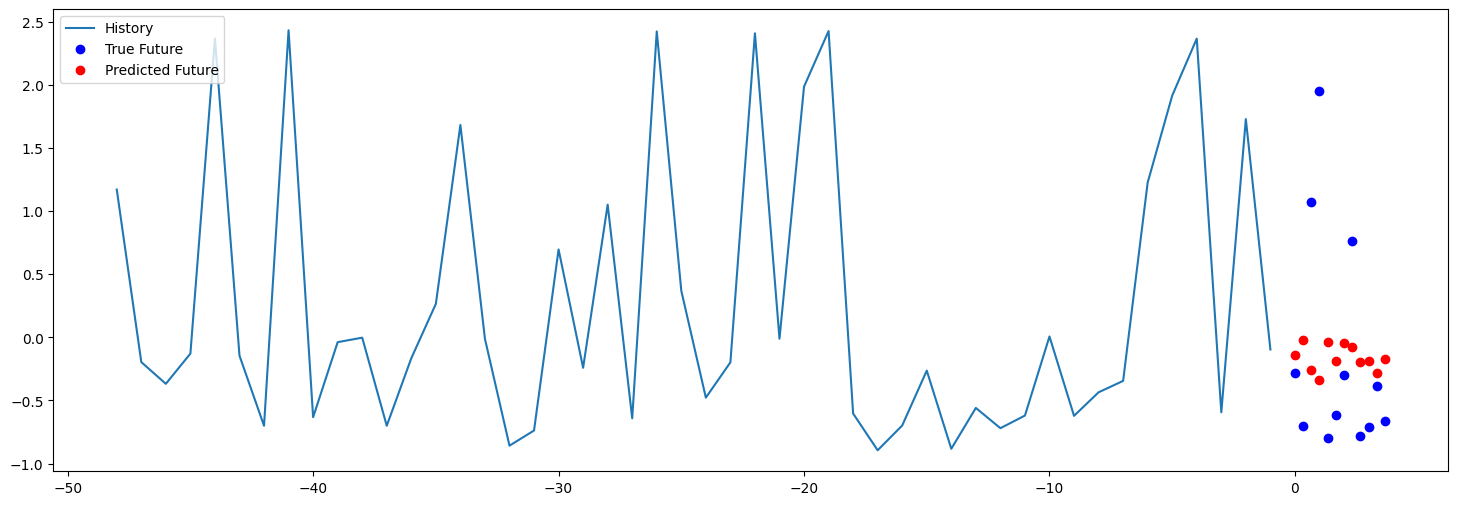

4/4 [==============================] - 0s 4ms/step


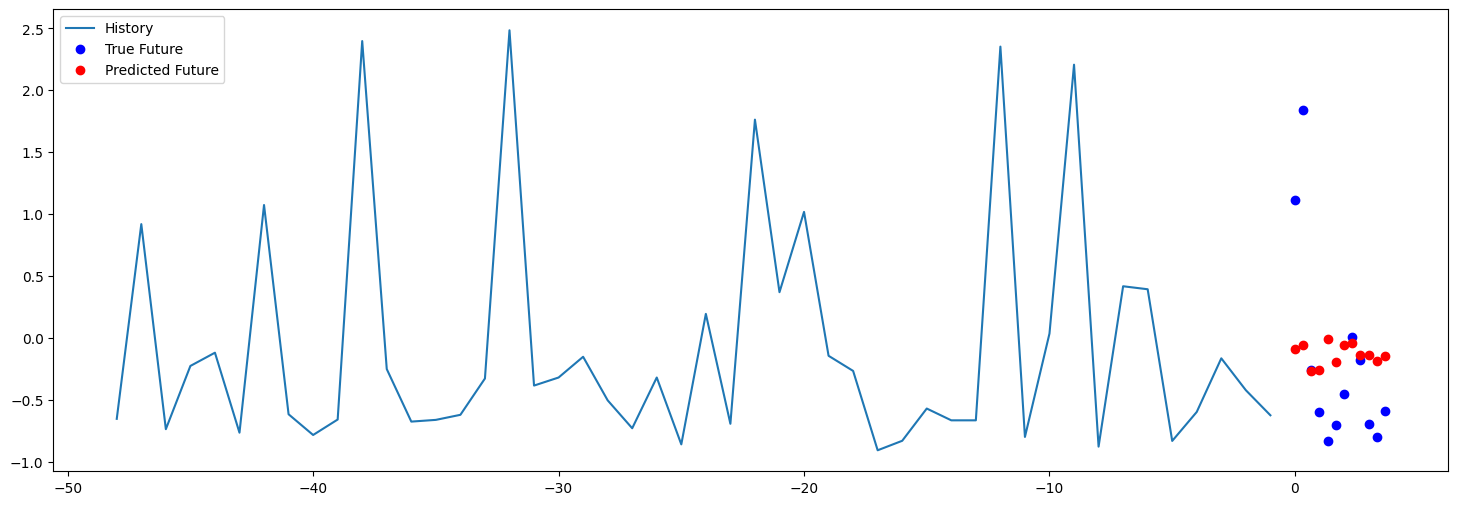

In [16]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

In [17]:
import tensorflow as tf
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().batch(BATCH_SIZE)
val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE)

predicted_cpus = []
original_cpus = []
history_cpus = []


for x, y in train_data_multi:
    hx_cpu = np.squeeze(x[0])[:,1]
    history_cpus.append(hx_cpu)

for x, y in val_data_multi:
    prediction = multi_step_model.predict(x, verbose = 0)[0]
    ori_cpus = np.squeeze(y[0])
    
    predicted_cpus.append(prediction)
    original_cpus.append(ori_cpus)
    

predicted_cpu_usage = np.concatenate(predicted_cpus, axis=0)
original_cpu_usage = np.concatenate(original_cpus, axis=0)
history_cpu_usage = np.concatenate(history_cpus, axis=0)   

2023-06-12 16:43:03.757384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [2842,12]
	 [[{{node Placeholder/_1}}]]
2023-06-12 16:43:03.786752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [591,12]
	 [[{{node Placeholder/_1}}]]
2023-06-12 16:43:04.153303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_

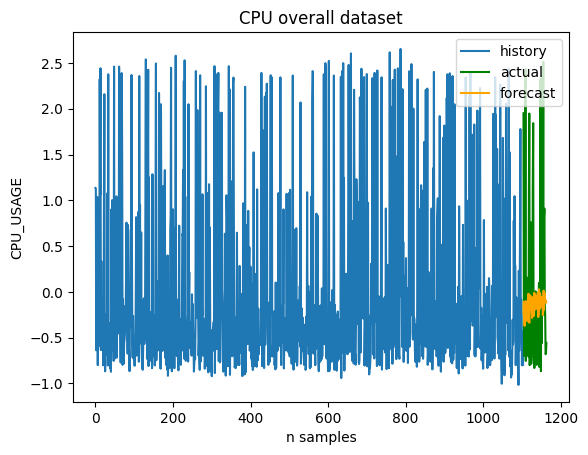

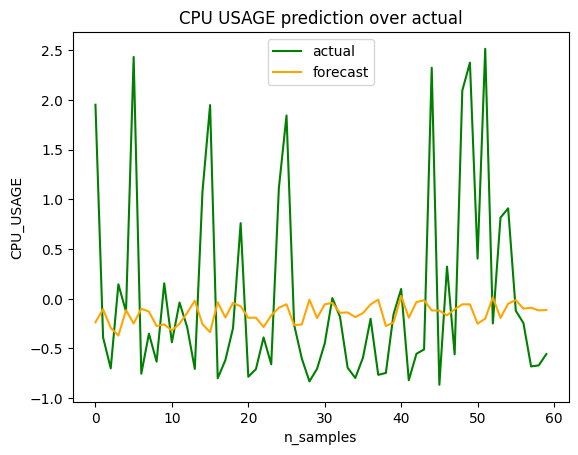

In [18]:
plt.title("CPU overall dataset") 
plt.xlabel("n samples") 
plt.ylabel("CPU_USAGE") 
plt.plot(range(len(history_cpu_usage)),history_cpu_usage, label="history") 
plt.plot(range(len(history_cpu_usage), len(history_cpu_usage) + len(predicted_cpu_usage)),original_cpu_usage, label="actual", color="green")
plt.plot(range(len(history_cpu_usage), len(history_cpu_usage) + len(predicted_cpu_usage)),predicted_cpu_usage, label="forecast" , color="orange")

plt.legend()
plt.show()

x = range(len(predicted_cpu_usage))
plt.title("CPU USAGE prediction over actual") 
plt.xlabel("n_samples") 
plt.ylabel("CPU_USAGE") 
plt.plot(x,original_cpu_usage, label="actual", color="green")
plt.plot(x,predicted_cpu_usage, label="forecast", color="orange")
plt.legend()


In [19]:
my_mean_absolute_percentage_error(original_cpu_usage, predicted_cpu_usage)

108.8124659357329

In [20]:
from tensorflow.keras.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(original_cpu_usage, predicted_cpu_usage)

<tf.Tensor: shape=(), dtype=float32, numpy=108.81248>

# MULTIVARIATE TO SINGLE FEATURE RAM

In [21]:
x_train_multi, y_train_multi = multivariate_data(scaled_df, scaled_df[:, 0], 0,
                                                 training_size, PAST_WINDOW_SIZE,
                                                 FUTURE_WINDOW_SIZE, STEP)
x_val_multi, y_val_multi = multivariate_data(scaled_df, scaled_df[:, 0],
                                             training_size, None, PAST_WINDOW_SIZE,
                                                 FUTURE_WINDOW_SIZE, STEP)
BATCH_SIZE = 128

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(FUTURE_WINDOW_SIZE))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
print(multi_step_model.summary())

early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)
multi_step_history = multi_step_model.fit(train_data_multi,
                                          epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=EVALUATION_INTERVAL,
                                          callbacks=[early_stopping])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 48, 32)            4608      
                                                                 
 lstm_3 (LSTM)               (None, 16)                3136      
                                                                 
 dense_1 (Dense)             (None, 12)                204       
                                                                 
Total params: 7,948
Trainable params: 7,948
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10


2023-06-12 16:43:17.017832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 16:43:17.018394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-12 16:43:17.019145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

199/200 [============================>.] - ETA: 0s - loss: 0.1517

2023-06-12 16:43:22.821926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [591,12]
	 [[{{node Placeholder/_1}}]]
2023-06-12 16:43:22.939602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 16:43:22.940401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 

200/200 [==============================] - 9s 36ms/step - loss: 0.1511 - val_loss: 2.1164
Epoch 2/10
200/200 [==============================] - 5s 26ms/step - loss: 0.0768 - val_loss: 2.2196
Epoch 3/10
200/200 [==============================] - 5s 26ms/step - loss: 0.0706 - val_loss: 2.2344
Epoch 4/10
200/200 [==============================] - 5s 26ms/step - loss: 0.0608 - val_loss: 2.1570


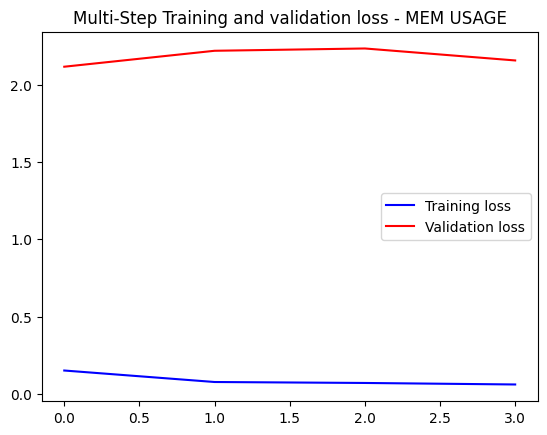

In [22]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss - MEM USAGE')

In [23]:
multi_step_model.save('best_multistep_multivariate_to_single_mem.h5')

In [24]:
from tensorflow import keras
multi_step_model = keras.models.load_model("./best_multistep_multivariate_to_single_mem.h5")

2023-06-12 16:43:46.241164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 16:43:46.241978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-12 16:43:46.242556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-12 16:43:49.334244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [591,12]
	 [[{{node Placeholder/_1}}]]
2023-06-12 16:43:49.507285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 16:43:49.507912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 

4/4 [==============================] - 0s 8ms/step


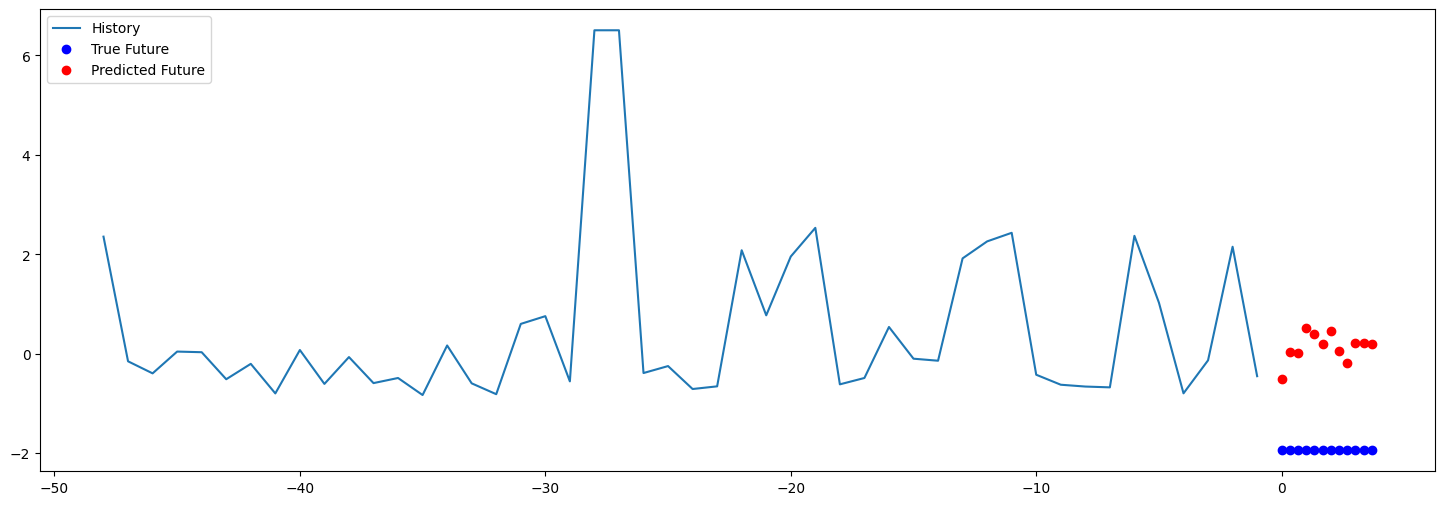

4/4 [==============================] - 0s 4ms/step


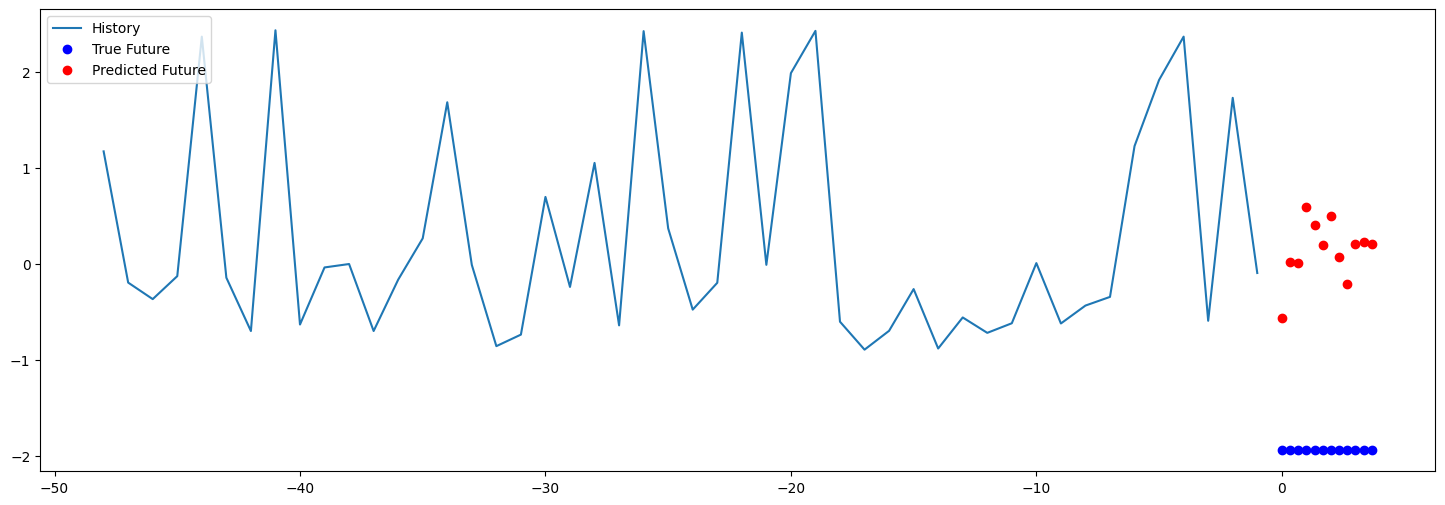

4/4 [==============================] - 0s 4ms/step


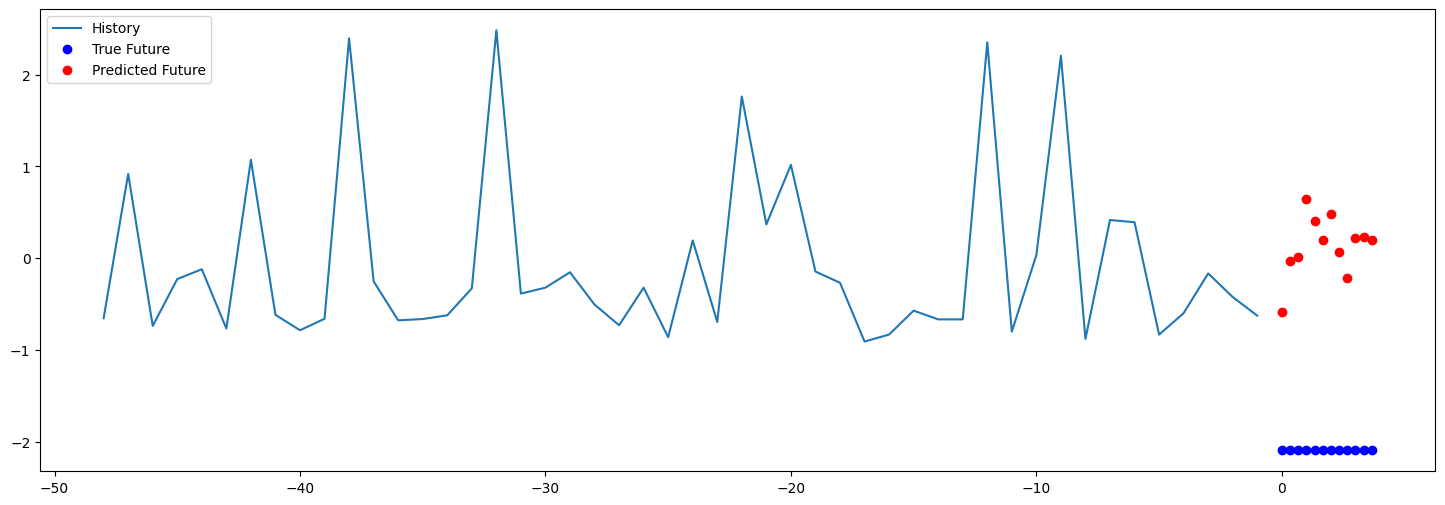

In [25]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

In [28]:
import tensorflow as tf
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().batch(BATCH_SIZE)
val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE)

predicted_mems = []
original_mems = []
history_mems = []


for x, y in train_data_multi:
    hx_mem = np.squeeze(x[0])[:,0]
    history_mems.append(hx_mem)

for x, y in val_data_multi:
    prediction = multi_step_model.predict(x, verbose = 0)[0]
    ori_mems = np.squeeze(y[0])
    
    predicted_mems.append(prediction)
    original_mems.append(ori_mems)
    

predicted_mem_usage = np.concatenate(predicted_mems, axis=0)
original_mem_usage = np.concatenate(original_mems, axis=0)
history_mem_usage = np.concatenate(history_mems, axis=0)   

2023-06-12 16:44:16.060624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [2842,12]
	 [[{{node Placeholder/_1}}]]
2023-06-12 16:44:16.107735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [591,12]
	 [[{{node Placeholder/_1}}]]


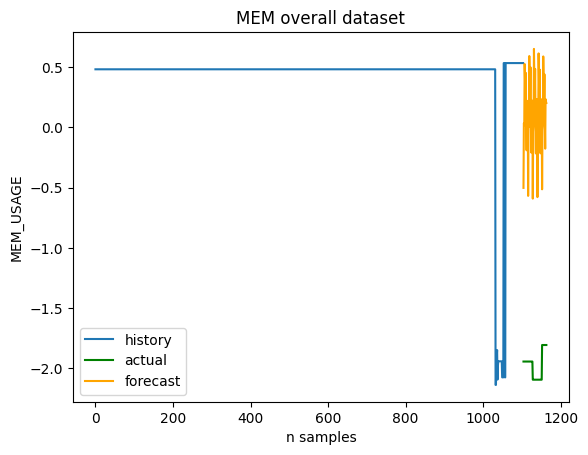

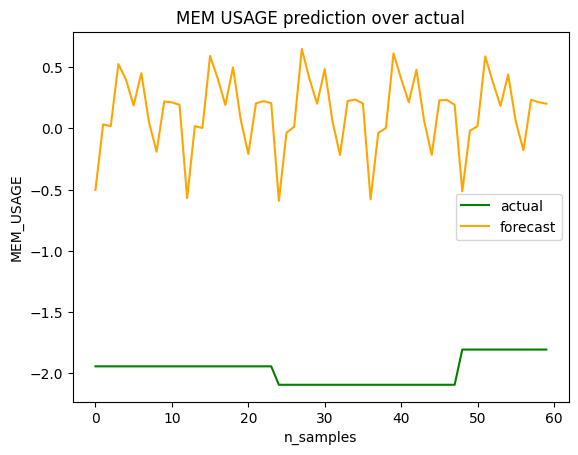

In [32]:
plt.title("MEM overall dataset") 
plt.xlabel("n samples") 
plt.ylabel("MEM_USAGE") 
plt.plot(range(len(history_mem_usage)),history_mem_usage, label="history") 
plt.plot(range(len(history_mem_usage), len(history_mem_usage) + len(predicted_mem_usage)),original_mem_usage, label="actual", color="green") 
plt.plot(range(len(history_mem_usage), len(history_mem_usage) + len(predicted_mem_usage)),predicted_mem_usage, label="forecast", color="orange")

plt.legend()
plt.show()

x = range(len(predicted_mem_usage))
plt.title("MEM USAGE prediction over actual") 
plt.xlabel("n_samples") 
plt.ylabel("MEM_USAGE") 
plt.plot(x,original_mem_usage, label="actual", color="green") 
plt.plot(x,predicted_mem_usage, label="forecast", color="orange")
plt.legend()


In [34]:
my_mean_absolute_percentage_error(original_mem_usage, predicted_mem_usage)

106.84385827337057

# SINGLE FEATURE TEMP

In [35]:
x_train_multi, y_train_multi = multivariate_data(scaled_df, scaled_df[:, 2], 0,
                                                 training_size, PAST_WINDOW_SIZE,
                                                 FUTURE_WINDOW_SIZE, STEP)
x_val_multi, y_val_multi = multivariate_data(scaled_df, scaled_df[:, 2],
                                             training_size, None, PAST_WINDOW_SIZE,
                                                 FUTURE_WINDOW_SIZE, STEP)
BATCH_SIZE = 128

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(FUTURE_WINDOW_SIZE))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
print(multi_step_model.summary())

early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)
multi_step_history = multi_step_model.fit(train_data_multi,
                                          epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=EVALUATION_INTERVAL,
                                          callbacks=[early_stopping])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 48, 32)            4608      
                                                                 
 lstm_5 (LSTM)               (None, 16)                3136      
                                                                 
 dense_2 (Dense)             (None, 12)                204       
                                                                 
Total params: 7,948
Trainable params: 7,948
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10


2023-06-12 16:44:55.720533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 16:44:55.721364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-12 16:44:55.721935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

199/200 [============================>.] - ETA: 0s - loss: 0.3935

2023-06-12 16:45:01.548247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [591,12]
	 [[{{node Placeholder/_1}}]]
2023-06-12 16:45:01.646947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 16:45:01.647590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 

200/200 [==============================] - 7s 27ms/step - loss: 0.3940 - val_loss: 0.9555
Epoch 2/10
200/200 [==============================] - 5s 26ms/step - loss: 0.2253 - val_loss: 0.2020
Epoch 3/10
200/200 [==============================] - 5s 26ms/step - loss: 0.1705 - val_loss: 0.1204
Epoch 4/10
200/200 [==============================] - 5s 26ms/step - loss: 0.1429 - val_loss: 0.2098
Epoch 5/10
200/200 [==============================] - 5s 26ms/step - loss: 0.1316 - val_loss: 0.1288
Epoch 6/10
200/200 [==============================] - 5s 26ms/step - loss: 0.1218 - val_loss: 0.0489
Epoch 7/10
200/200 [==============================] - 5s 26ms/step - loss: 0.1135 - val_loss: 0.0970
Epoch 8/10
200/200 [==============================] - 5s 26ms/step - loss: 0.1057 - val_loss: 0.1089
Epoch 9/10
200/200 [==============================] - 5s 26ms/step - loss: 0.1017 - val_loss: 0.1112


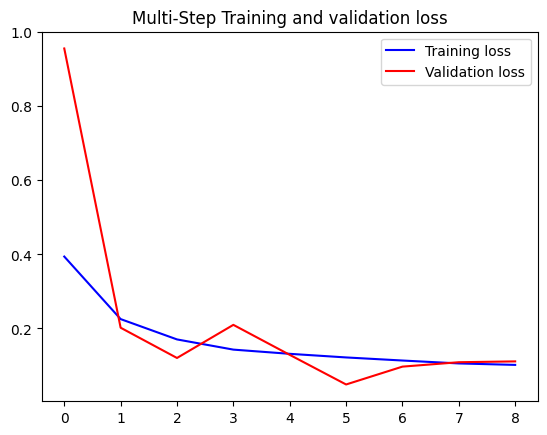

In [36]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

In [37]:
multi_step_model.save('best_multistep_multivariate_to_single_temp.h5')

In [38]:
from tensorflow import keras
multi_step_model = keras.models.load_model("./best_multistep_multivariate_to_single_temp.h5")

2023-06-12 16:45:49.864479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 16:45:49.865587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-12 16:45:49.866154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-12 16:45:51.067525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [591,12]
	 [[{{node Placeholder/_1}}]]


4/4 [==============================] - 0s 4ms/step


2023-06-12 16:45:51.270560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 16:45:51.271421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-12 16:45:51.272074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

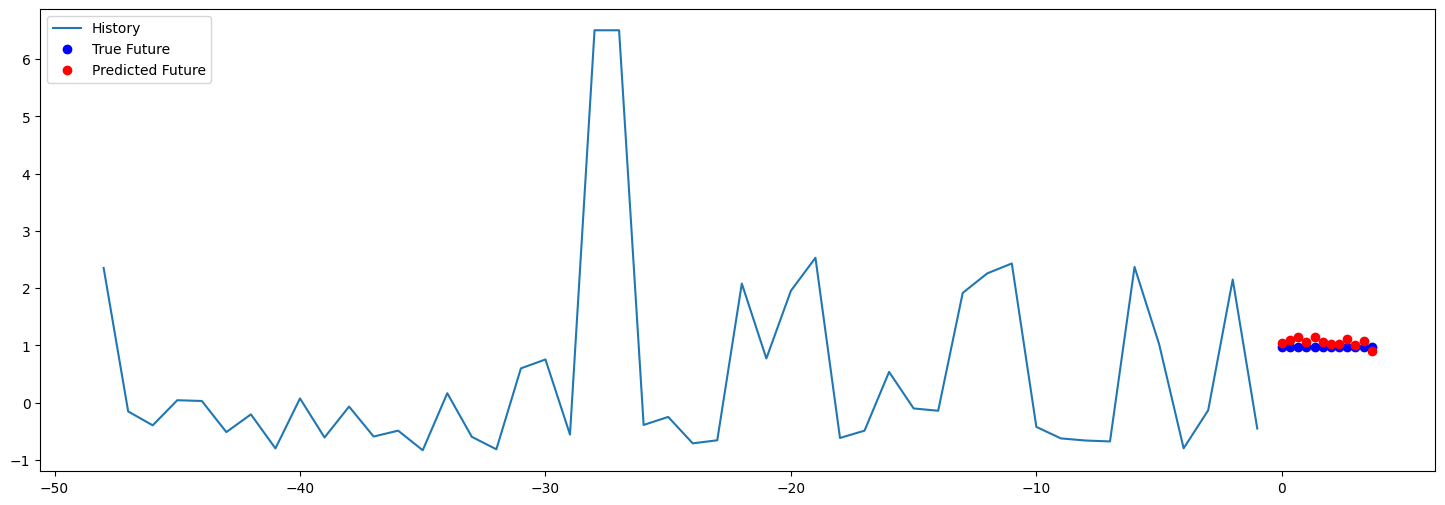

4/4 [==============================] - 0s 4ms/step


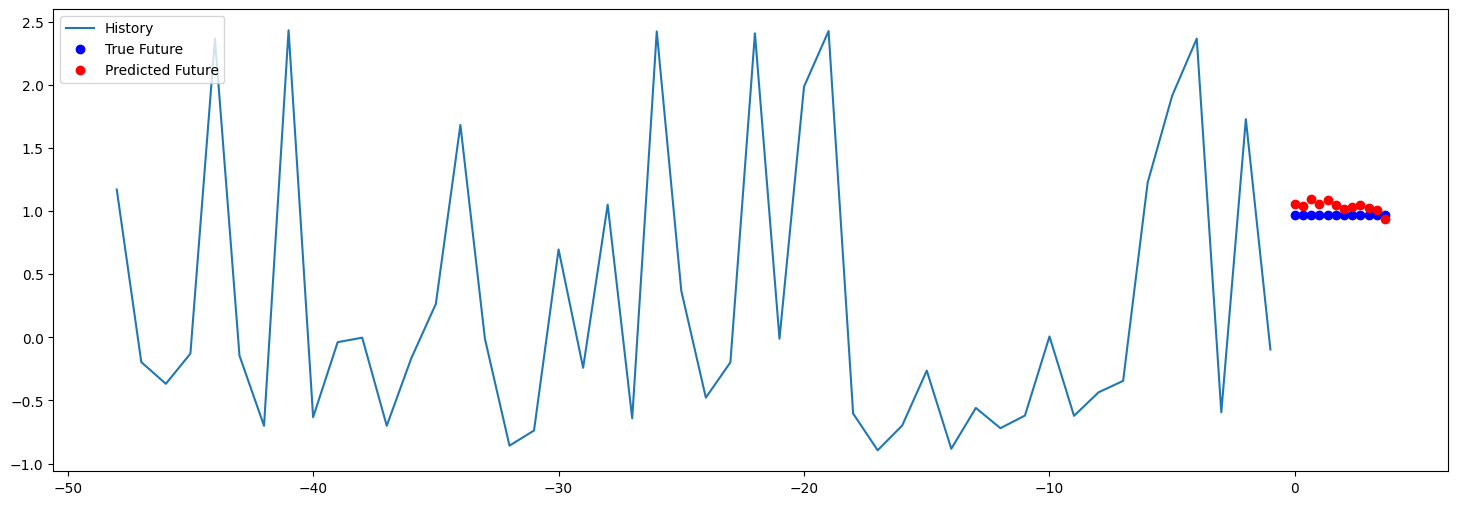

4/4 [==============================] - 0s 4ms/step


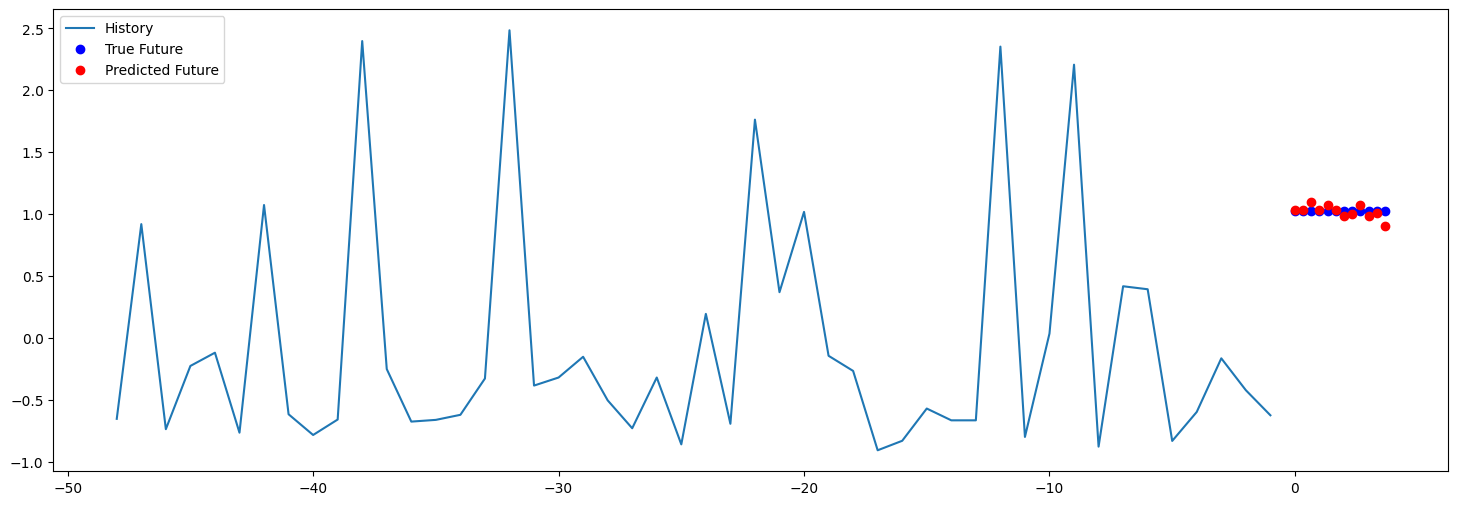

In [39]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

In [40]:
import tensorflow as tf
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().batch(BATCH_SIZE)
val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE)

predicted_temps = []
original_temps = []
history_temps = []


for x, y in train_data_multi:
    hx_temp = np.squeeze(x[0])[:,2]
    history_temps.append(hx_temp)

for x, y in val_data_multi:
    prediction = multi_step_model.predict(x, verbose = 0)[0]
    ori_mems = np.squeeze(y[0])
    
    predicted_temps.append(prediction)
    original_temps.append(ori_mems)
    

predicted_temp_usage = np.concatenate(predicted_temps, axis=0)
original_temp_usage = np.concatenate(original_temps, axis=0)
history_temp_usage = np.concatenate(history_temps, axis=0)   

2023-06-12 16:45:51.790146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [2842,12]
	 [[{{node Placeholder/_1}}]]
2023-06-12 16:45:51.803292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [591,12]
	 [[{{node Placeholder/_1}}]]
2023-06-12 16:45:52.251669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_

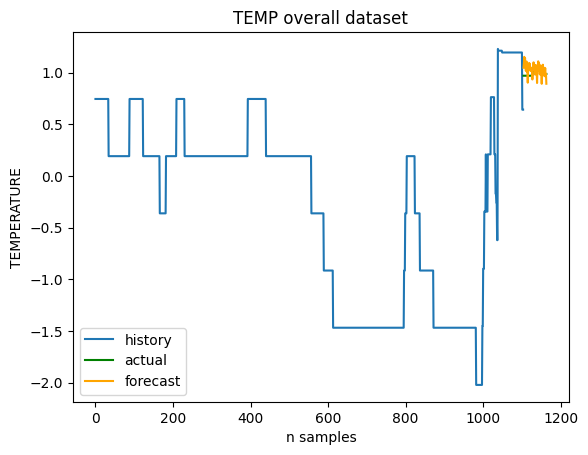

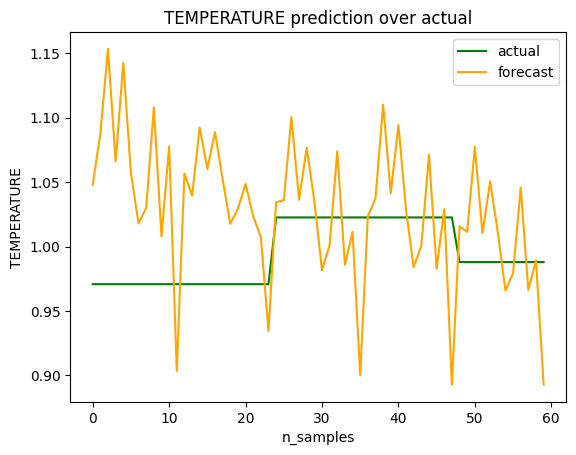

In [41]:
plt.title("TEMP overall dataset") 
plt.xlabel("n samples") 
plt.ylabel("TEMPERATURE") 
plt.plot(range(len(history_temp_usage)),history_temp_usage, label="history") 
plt.plot(range(len(history_temp_usage), len(history_temp_usage) + len(predicted_temp_usage)),original_temp_usage, label="actual", color="green") 
plt.plot(range(len(history_temp_usage), len(history_temp_usage) + len(predicted_temp_usage)),predicted_temp_usage, label="forecast", color="orange")

plt.legend()
plt.show()

x = range(len(predicted_temp_usage))
plt.title("TEMPERATURE prediction over actual") 
plt.xlabel("n_samples") 
plt.ylabel("TEMPERATURE") 
plt.plot(x,original_temp_usage, label="actual", color="green") 
plt.plot(x,predicted_temp_usage, label="forecast", color="orange")
plt.legend()


In [42]:
my_mean_absolute_percentage_error(original_temp_usage, predicted_temp_usage)

5.851890226479954

--------------------

#### Overall the only metrics which reaches a reasonable accuracy is the temperature with 94.15% of accuracy (1-MAPE)